In [1]:
# db connection

import pymysql
from sqlalchemy import create_engine
import keyring
import platform
import numpy as np

user = 'root'
pw = keyring.get_password('macmini_db', user)
host = '192.168.219.106' if platform.system() == 'Windows' else '127.0.0.1'
port = 3306
db = 'stock'


# # connect DB
# engine = create_engine(f'mysql+pymysql://{self.user}:{self.pw}@{self.host}:{self.port}/{self.db}')

# con = pymysql.connect(
#     user=user,
#     passwd=pw,
#     host=host,
#     db=db,
#     charset='utf8'
# )
        
# mycursor = con.cursor()

# COLUMNS

In [2]:
# base data
COLUMNS_STOCK_DATA = ['date', 'open', 'high', 'low', 'close', 'volume']
COLUMNS_TRAINING_DATA = ['open', 'high', 'low', 'close', 'volume', 'close_ma5', 'volume_ma5', 'close_ma5_ratio', 'volume_ma5_ratio',
       'open_close_ratio', 'open_prev_close_ratio', 'high_close_ratio',
       'low_close_ratio', 'close_prev_close_ratio', 'volume_prev_volume_ratio',
       'close_ma10', 'volume_ma10', 'close_ma10_ratio', 'volume_ma10_ratio',
       'close_ma20', 'volume_ma20', 'close_ma20_ratio', 'volume_ma20_ratio',
       'close_ma60', 'volume_ma60', 'close_ma60_ratio', 'volume_ma60_ratio',
       'close_ma120', 'volume_ma120', 'close_ma120_ratio',
       'volume_ma120_ratio', 'close_ma240', 'volume_ma240',
       'close_ma240_ratio', 'volume_ma240_ratio', 'upper_bb',
       'lower_bb', 'bb_pb', 'bb_width', 'macd',
       'macd_signal', 'macd_oscillator', 'rs', 'rsi']
# COLUMNS_TRAINING_DATA = ['open', 'high', 'low', 'close', 'volume', 'close_ma5', 'volume_ma5', 'close_ma5_ratio', 'volume_ma5_ratio',
#        'open_close_ratio', 'open_prev_close_ratio', 'high_close_ratio',
#        'low_close_ratio', 'close_prev_close_ratio', 'volume_prev_volume_ratio',
#        'close_ma10', 'volume_ma10', 'close_ma10_ratio', 'volume_ma10_ratio',
#        'close_ma20', 'volume_ma20', 'close_ma20_ratio', 'volume_ma20_ratio',
#        'close_ma60', 'volume_ma60', 'close_ma60_ratio', 'volume_ma60_ratio',
#        'close_ma120', 'volume_ma120', 'close_ma120_ratio',
#        'volume_ma120_ratio', 'close_ma240', 'volume_ma240',
#        'close_ma240_ratio', 'volume_ma240_ratio', 'middle_bb', 'upper_bb',
#        'lower_bb', 'bb_pb', 'bb_width', 'ema_short', 'ema_long', 'macd',
#        'macd_signal', 'macd_oscillator', 'close_change', 'close_up',
#        'close_down', 'rs', 'rsi']

# UTILITIES

## Get stock price

In [3]:
import pandas as pd
import pymysql
from sqlalchemy import create_engine


# get us stock price of a specific ticker
def get_prices_from_ticker(ticker, fro=None, to=None):

    # connect DB
    engine = create_engine(f'mysql+pymysql://{user}:{pw}@{host}:{port}/{db}')

    con = pymysql.connect(
        user=user,
        passwd=pw,
        host=host,
        db=db,
        charset='utf8'
    )
            
    mycursor = con.cursor()
    
    if fro is not None:
        if to is not None:               
            query = f""" 
                    SELECT * FROM price_global
                    WHERE ticker = '{ticker}'
                    AND date BETWEEN '{fro}' AND '{to}' 
                    """
        else:
            query = f""" 
                    SELECT * FROM price_global
                    WHERE ticker = '{ticker}'
                    AND date >= '{fro}'
                    """
    
    else:
        if to is not None:
            query = f""" 
                    SELECT * FROM price_global
                    WHERE ticker = '{ticker}'
                    AND date <= '{to}' 
                    """
        else:
            query = f""" 
                    SELECT * FROM price_global
                    WHERE ticker = '{ticker}'
                    """
            
    print(query)
    prices = pd.read_sql(query, con=engine)
    con.close()
    engine.dispose()
    return prices

## Time and Date

In [4]:
# utility functions
import time
import datetime
import numpy as np

# str format on date, time
FORMAT_DATE = '%Y%m%d'
FORMAT_DATETIME = '%Y%m%d%H%M%S'

def get_today_str():
    today = datetime.datetime.combine(
        datetime.date.today(), datetime.datetime.min.time()
    )
    today_str = today.strftime(FORMAT_DATE)
    return today_str

def get_time_str():
    return datetime.datetime.fromtimestamp(
        int(time.time())
    ).strftime(FORMAT_DATETIME)
    
def sigmoid(x):
    x = max(min(x, 10), -10)
    return 1. / (1. + np.exp(-x))

In [5]:
stock_code = 'AAPL'
fro = '2010-01-01'
to = '2020-12-31'
df = get_prices_from_ticker(stock_code, fro=fro, to=to)

 
                    SELECT * FROM price_global
                    WHERE ticker = 'AAPL'
                    AND date BETWEEN '2010-01-01' AND '2020-12-31' 
                    


## Preprocessing

In [6]:
COLUMNS_STOCK_RATIO_DATA = [
    'open_close_ratio', 'open_prev_close_ratio', 'high_close_ratio', 'low_close_ratio',
    'close_prev_close_ratio', 'volume_prev_volume_ratio',
]

def preprocess(data):
    
    # moving average
    windows = [5, 10, 20, 60, 120, 240]
    for window in windows:
        data[f'close_ma{window}'] = data['close'].rolling(window).mean()
        data[f'volume_ma{window}'] = data['volume'].rolling(window).mean()
        data[f'close_ma{window}_ratio'] = (data['close'] - data[f'close_ma{window}']) / data[f'close_ma{window}']
        data[f'volume_ma{window}_ratio'] = (data['volume'] - data[f'volume_ma{window}']) / data[f'volume_ma{window}']
        data['open_close_ratio'] = (data['open'].values - data['close'].values) / data['close'].values
        data['open_prev_close_ratio'] = np.zeros(len(data))
        data.loc[1:, 'open_prev_close_ratio'] = (data['open'][1:].values - data['close'][:-1].values) / data['close'][:-1].values
        data['high_close_ratio'] = (data['high'].values - data['close'].values) / data['close'].values
        data['low_close_ratio'] = (data['low'].values - data['close'].values) / data['close'].values
        data['close_prev_close_ratio'] = np.zeros(len(data))
        data.loc[1:, 'close_prev_close_ratio'] = (data['close'][1:].values - data['close'][:-1].values) / data['close'][:-1].values 
        data['volume_prev_volume_ratio'] = np.zeros(len(data))
        data.loc[1:, 'volume_prev_volume_ratio'] = (
            # if volume is 0, change it into non zero value exploring previous volume continuously
            (data['volume'][1:].values - data['volume'][:-1].values) / data['volume'][:-1].replace(to_replace=0, method='ffill').replace(to_replace=0, method='bfill').values
        )
    
    # Bollinger band
    data['middle_bb'] = data['close'].rolling(20).mean()
    data['upper_bb'] = data['middle_bb'] + 2 * data['close'].rolling(20).std()
    data['lower_bb'] = data['middle_bb'] - 2 * data['close'].rolling(20).std()
    data['bb_pb'] = (data['close'] - data['lower_bb']) / (data['upper_bb'] - data['lower_bb'])
    data['bb_width'] = (data['upper_bb'] - data['lower_bb']) / data['middle_bb']
    
    # MACD
    macd_short, macd_long, macd_signal = 12, 26, 9
    data['ema_short'] = data['close'].ewm(macd_short).mean()
    data['ema_long'] = data['close'].ewm(macd_long).mean()
    data['macd'] = data['ema_short'] - data['ema_long']
    data['macd_signal'] = data['macd'].ewm(macd_signal).mean()
    data['macd_oscillator'] = data['macd'] - data['macd_signal']
    
    # RSI
    data['close_change'] = data['close'].diff()
    # data['close_up'] = np.where(data['close_change'] >=0, df['close_change'], 0)
    data['close_up'] = data['close_change'].apply(lambda x: x if x >= 0 else 0)
    # data['close_down'] = np.where(data['close_change'] < 0, df['close_change'].abs(), 0)
    data['close_down'] = data['close_change'].apply(lambda x: -x if x < 0 else 0)
    data['rs'] = data['close_up'].ewm(alpha=1/14, min_periods=14).mean() / data['close_down'].ewm(alpha=1/14, min_periods=14).mean()
    data['rsi'] = 100 - (100 / (1 + data['rs']))
    
    
    return data

In [7]:
df_adj = preprocess(df)

## Load data

In [8]:
def load_data(stock_code, fro, to):
    df = get_prices_from_ticker(stock_code, fro, to)
    df_adj = preprocess(df).dropna().reset_index(drop=True)
    # df_adj.dropna(inplace=True).reset_index(drop=True)
    
    stock_data = df_adj[COLUMNS_STOCK_DATA]
    training_data = df_adj[COLUMNS_TRAINING_DATA]
    
    return df_adj, stock_data, training_data.values

In [9]:
df_adj, stock_data, training_data = load_data(stock_code, fro, to)

 
                    SELECT * FROM price_global
                    WHERE ticker = 'AAPL'
                    AND date BETWEEN '2010-01-01' AND '2020-12-31' 
                    


# ENVIRONMENT

In [10]:
# environment

import numpy as np
import pandas as pd

# environment

class Environment:
    ''' 
    Attribute
    ---------
    - stock_data : stock price data such as 'open', 'close', 'volume', 'bb', 'rsi', etc.
    - state : current state
    - idx : current postion of stock data
    
    
    Functions
    --------
    - reset() : initialize idx and state
    - step() : move idx into next postion and get a new state
    - get_price() : get close price of current state
    - get_state() : get current state
    '''
    
    def __init__(self, stock_data=None):
        self.PRICE_IDX = 4  # index postion of close price
        self.stock_data = stock_data
        self.state = None
        self.idx = -1
        
    def reset(self):
        self.state = None
        self.idx = -1
        
    def step(self):
        # if there is no more idx, return None
        if len(self.stock_data) > self.idx + 1:
            self.idx += 1
            self.state = self.stock_data.iloc[self.idx]
            return self.state
        return None
    
    def get_price(self):
        # return close price
        if self.state is not None:
            return self.state[self.PRICE_IDX]
        return None
    
    def get_state(self):
        # return current state
        if self.state is not None:
            return self.state
        return None
        

In [11]:
a = Environment(df_adj)
a.reset()
a.step()
a.step()
a.get_price()

11.441429138183594

In [12]:
a.step()
a.get_state()

date                         2010-12-16
high                            11.4675
low                           11.521786
open                          11.432143
close                         11.473214
volume                         9.713216
adj_close                   322030800.0
ticker                             AAPL
close_ma5                     11.458071
volume_ma5                     9.700397
close_ma5_ratio                0.001322
volume_ma5_ratio               0.001321
open_close_ratio               -0.00358
open_prev_close_ratio         -0.000812
high_close_ratio              -0.000498
low_close_ratio                0.004233
close_prev_close_ratio         0.002778
volume_prev_volume_ratio       0.002778
close_ma10                    11.431071
volume_ma10                    9.677539
close_ma10_ratio               0.003687
volume_ma10_ratio              0.003687
close_ma20                    11.304143
volume_ma20                    9.570082
close_ma20_ratio               0.014957


# AGENT

In [13]:
# agent
import numpy as np

class Agent:
    ''' 
    Attributes
    --------
    - enviroment : instance of environment
    - initial_balance : initial capital balance
    - min_trading_price : minimum trading price
    - max_trading_price : maximum trading price
    - balance : cash balance
    - num_stocks : obtained stocks
    - portfolio_value : value of portfolios (balance + price * num_stocks)
    - num_buy : number of buying
    - num_sell : number of selling
    - num_hold : number of holding
    - ratio_hold : ratio of holding stocks
    - profitloss : current profit or loss
    - avg_buy_price_ratio : the ratio average price of a stock bought to the current price
    
    Functions
    --------
    - reset() : initialize an agent
    - set_balance() : initialize balance
    - get_states() : get the state of an agent
    - decide_action() : exploration or exploitation behavior according to the policy net
    - validate_action() : validate actions
    - decide_trading_unit() : decide how many stocks are sold or bought
    - act() : act the actions
    '''
    
    # agent state dimensions
    ## (ratio_hold, profit-loss ratio, current price to avg_buy_price ratio)
    STATE_DIM = 3
    
    # trading charge and tax
    TRADING_CHARGE = 0.00015    # trading charge 0.015%
    TRADING_TAX = 0.02          # trading tax = 0.2%
    
    # action space
    ACTION_BUY = 0      # buy
    ACTION_SELL = 1     # sell
    ACTION_HOLD = 2     # hold
    
    # get probabilities from neural nets
    ACTIONS = [ACTION_BUY, ACTION_SELL, ACTION_HOLD]
    NUM_ACTIONS = len(ACTIONS)      # output number from nueral nets
    
    def __init__(self, environment, initial_balance, min_trading_price, max_trading_price):
        # get current price from the environment
        self.environment = environment
        self.initial_balance = initial_balance
        
        # minumum and maximum trainding price
        self.min_trading_price = min_trading_price
        self.max_trading_price = max_trading_price
        
        # attributes for an agent class
        self.balance = initial_balance
        self.num_stocks = 0
        
        # value of portfolio : balance + num_stocks * {current stock price}
        self.portfolio_value = 0
        self.num_buy = 0
        self.num_sell = 0
        self.num_hold = 0
        
        # the state of Agent class
        self.ratio_hold = 0
        self.profitloss = 0
        self.avg_buy_price = 0
        
        
    def reset(self):
        self.balance = self.initial_balance
        self.num_stocks = 0
        self.portfolio_value = self.balance
        self.num_buy = 0
        self.num_sell = 0
        self.num_hold = 0
        self.ratio_hold = 0
        self.profitloss = 0
        self.avg_buy_price = 0
        
    def set_initial_balance(self, balance):
        self.initial_balance = balance
        
    def get_states(self):
        # return ratio hold, profit/loss ratio and 
        # ratio_hold = num_stokcs / (portfoilo_value / price) = (num_stocks * price) / portfolio_value
        self.ratio_hold = self.num_stocks * self.environment.get_price() / self.portfolio_value
        
        return (
            self.ratio_hold,
            self.profitloss,        # profitloss = (portfolio_value / initial_balance) - 1
            (self.environment.get_price() / self.avg_buy_price) - 1 if self.avg_buy_price > 0 else 0
        )
        
    def decide_action(self, pred_value, pred_policy, epsilon):
        # act randomly with epsilon probability, act according to neural network  with (1 - epsilon) probability
        confidence = 0
        
        # if theres is a pred_policy, follow it, otherwise follow a pred_value
        pred = pred_policy
        if pred is None:
            pred = pred_value
            
        # there is no prediction from both pred_policy and pred_value, explore!
        if pred is None:
            epsilon = 1
        else:
            maxpred = np.max(pred)
            # if values for actions are euqal, explore!
            if (pred == maxpred).all():
                epsilon = 1
        
            # if the diffrence between buying and selling prediction policy value is less than 0.05, explore!
            if pred_policy is not None:
                if np.max(pred_policy) - np.min(pred_policy) < 0.05:
                    epsilon = 1
            # if pred is not None:
            #     if np.max(pred) - np.min(pred) < 0.05:
            #         epsilon = 1     
                    
        # decide whether exploration will be done or not
        if np.random.rand() < epsilon:
            exploration = True
            action = np.random.randint(self.NUM_ACTIONS) 
        else: 
            exploration = False
            action = np.argmax(pred)
            
        confidence = .5
        if pred_policy is not None:
            confidence = pred[action]  
        elif pred_value is not None:
            confidence = sigmoid(pred[action])
            
        return action, confidence, exploration
    
    def validate_action(self, action):
        # validate if the action is available
        if action == Agent.ACTION_BUY:
            # check if al least one stock can be bought.
            if self.balance < self.environment.get_price() * (1 + self.TRADING_CHARGE):
                return False
        elif action == Agent.ACTION_SELL:
            # check if there is any sotck that can be sold
            if self.num_stocks <= 0:
                return False
        
        return True
    
    
    def decide_trading_unit(self, confidence):
        # adjust number of stocks for buying and selling according to confidence level
        if np.isnan(confidence):
            return self.min_trading_price
        
        # set buying price range between self.min_trading_price + added_trading_price [min_trading_price, max_trading_price]
        # in case that confidence > 1 causes the price over max_trading_price, we set min() so that the value cannot have larger value than self.max_trading_price - self.min_trading_price
        # in case that confidence < 0, we set max() so that added_trading_price cannot have negative value.
        added_trading_price = max(min(
            int(confidence * (self.max_trading_price - self.min_trading_price)),
            self.max_trading_price - self.min_trading_price
        ), 0)
        
        trading_price = self.min_trading_price + added_trading_price
        
        return max(int(trading_price / self.environment.get_price()), 1)
        
        
    
    def act(self, action, confidence):
        '''
        Arguments
        ---------
        - action : decided action from decide_action() method based on exploration or exploitation (0 or 1)
        - confidence : probabilitu from decide_action() method, the probability from policy network or the softmax probability from value network
        '''
        
        if not self.validate_action(action):
            action = Agent.ACTION_HOLD
        
        # get the price from the environment
        curr_price = self.environment.get_price()
        
        # buy
        if action == Agent.ACTION_BUY:
            # decide how many stocks will be bought
            trading_unit = self.decide_trading_unit(confidence)
            balance = (
                self.balance - curr_price * (1 + self.TRADING_CHARGE) * trading_unit
            )
            
            # if lacks of balance, buy maximum units within the amount of money available
            if balance < 0:
                trading_unit = min(
                    int(self.balance / (curr_price * (1 + self.TRADING_CHARGE))),
                    int(self.max_trading_price / curr_price)
                )
                
            # total amount of money with trading charge
            invest_amount = curr_price * (1 + self.TRADING_CHARGE) * trading_unit
            if invest_amount > 0:
                self.avg_buy_price = (self.avg_buy_price * self.num_stocks + curr_price * trading_unit) / (self.num_stocks + trading_unit)
                self.balance -= invest_amount
                self.num_stocks += trading_unit
                self.num_buy += 1
                
        # sell
        elif action == Agent.ACTION_SELL:
            # decide how many stocks will be sold
            trading_unit = self.decide_trading_unit(confidence)
            
            # if lacks of stocks, sell maximum units available
            trading_unit = min(trading_unit, self.num_stocks)
            
            # selling amount
            invest_amount = curr_price * (
                1 - (self.TRADING_TAX + self.TRADING_CHARGE)
            ) * trading_unit
            
            if invest_amount > 0:
                # update average buy price
                self.avg_buy_price = (self.avg_buy_price * self.num_stocks - curr_price * trading_unit) / (self.num_stocks - trading_unit) if self.num_stocks > trading_unit else 0
                self.num_stocks -= trading_unit
                self.balance += invest_amount
                self.num_sell += 1
                
        # hold
        elif action == Agent.ACTION_HOLD:
            self.num_hold += 1
            
        # update portfolio value
        self.portfolio_value = self.balance + curr_price * self.num_stocks
        self.profitloss = self.portfolio_value / self.initial_balance - 1
        
        return self.profitloss
    

# NETWORK

In [14]:
import threading
import abc
import numpy as np

import torch
import torch.nn.functional as F

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Network

In [16]:
class Network:
    ''' 
    Common attributes and methods for neural networks
    
    Attributes
    ---------
    - input_dim
    - output_dim
    - lr : learning rate
    - shared_network : head of neural network which is shared with various networks (e.g., A2C)
    - activation : activation layer function ('linear', 'sigmoid', 'tanh', 'softmax')
    - loss : loss function for networks
    - model : final neural network model
    
    Functions
    ---------
    - predict() : calculate value or probability of actions
    - train_on_batch() : generate batch data for training
    - save_model()
    - load_model()
    - get_share_network() : generate network head according to the networks
    '''
    
    # thread lock for A3C
    lock = threading.Lock()
    
    def __init__(self, input_dim=0, output_dim=0, num_steps=1, lr=0.001,
                 shared_network=None, activation='sigmoid', loss='mse'):
        self.input_dim = input_dim
        self.outpu_dim = output_dim
        self.num_steps = num_steps
        self.lr = lr
        self.shared_network = shared_network
        self.activation = activation
        self.loss = loss
        
        # data shape for various networks
        # CNN, LSTMNetwork has 3 dimensional shape, so we set input shape as (num_stpes, input_dim). In DNN, we set input shape as (input_dim, )
        inp = None
        if self.num_steps > 1:
            inp = (self.num_steps, input_dim)
        else:
            inp = (self.input_dim,)
        
        # in case that shared_network is used
        self.head = None
        if self.shared_network is None:
            self.head = self.get_network_head(inp, self.outpu_dim)
        else:
            self.head = self.shared_network
            
        # neural network model
        ## generate network model for head
        self.model = torch.nn.Sequential(self.head)
        if self.activation == 'linear':
            pass
        elif self.activation == 'relu':        
            self.model.add_module('activation', torch.nn.ReLU())   
        elif self.activation == 'leaky_relu':
            self.model.add_module('activation', torch.nn.LeakyReLU()) 
        elif self.activation == 'sigmoid':
            self.model.add_module('activation', torch.nn.Sigmoid())
        elif self.activation == 'tanh':
            self.model.add_module('activation', torch.nn.Tanh())
        elif self.activation == 'softmax':
            self.model.add_module('activation', torch.nn.Softmax(dim=1))
        self.model.apply(Network.init_weights)
        self.model.to(device)
        
        # optimizer
        self.optimizer = torch.optim.NAdam(self.model.parameters(), lr=self.lr)
        
        # loss function
        self.criterion = None
        if loss == 'mse':
            self.criterion = torch.nn.MSELoss()
        elif loss == 'binary_crossentropy':
            self.criterion = torch.nn.BCELoss()
            
    def predict(self, sample):
        # return prediction of buy, sell and hold on given sample
        # value network returns each actions' values on sample and policy network returns each actions' probabilities on sample
        with self.lock:
            # transform evaluation mode : deavtivate module used only on traininig such as Drop out
            self.model.eval()
            with torch.no_grad():
                x = torch.from_numpy(sample).float().to(device)
                pred = self.model(x).detach().cpu().numpy()
                pred = pred.flatten()
            return pred
        
    def train_on_batch(self, x, y):
        if self.num_steps > 1:
            x = np.array(x).reshape((-1, self.num_steps, self.input_dim))
        else:
            x = np.array(x).reshape((-1, self.input_dim))
        loss = 0
        with self.lock:
            # transform training mode
            self.model.train()
            _x = torch.from_numpy(x).float().to(device)
            _y = torch.from_numpy(y).float().to(device)
            y_pred = self.model(_x)
            _loss = self.criterion(y_pred, _y)
            self.optimizer.zero_grad()
            _loss.backward()
            self.optimizer.step()
            loss += _loss.item()
        return loss
    
    def train_on_batch_for_ppo(self, x, y, a, eps, K):
        if self.num_steps > 1:
            x = np.array(x).reshape((-1, self.num_steps, self.input_dim))
        else:
            x = np.array(x).reshape((-1, self.input_dim))
            
        loss = 0.
        with self.lock:
            self.model.train()
            _x = torch.from_numpy(x).float().to(device)
            _y = torch.from_numpy(y).float().to(device)
            probs = F.softmax(_y, dim=1)
            for _ in range(K):
                y_pred = self.model(_x)
                probs_pred = F.softmax(y_pred, dim=1)
                rto = torch.exp(torch.log(probs[:, a]) - torch.log(probs_pred[:, a]))
                rto_adv = rto * _y[:, a]
                clp_adv = torch.clamp(rto, 1 - eps, 1 + eps) * _y[:, a]
                _loss = -torch.min(rto_adv, clp_adv).mean()
                _loss.backward()
                self.optimizer.step()
                loss += _loss.item()
        return loss
    
    @classmethod
    def get_shared_network(cls, net='dnn', num_steps=1, input_dim=0, output_dim=0):
        if net == 'dnn':
            return DNN.get_network_head((input_dim, ), output_dim)
        elif net == 'lstm':
            return LSTMNetwork.get_network_head((num_steps, input_dim), output_dim)
        elif net == 'cnn':
            return CNN.get_network_head((num_steps, input_dim), output_dim)
        elif net == 'alex':
            print('alex')
            return AlexNet.get_network_head((num_steps, input_dim), output_dim)
        
    @abc.abstractmethod
    def get_network_head(inp, output_dim):
        pass
    
    @staticmethod
    def init_weights(m):
        # initialize weights as weighted normal distribution
        if isinstance(m, torch.nn.Linear) or isinstance(m, torch.nn.Conv1d):
            torch.nn.init.normal_(m.weight, std=0.01)
        elif isinstance(m, torch.nn.LSTM):
            for weights in m.all_weights:
                for weight in weights:
                    torch.nn.init.normal_(weight, std=0.01)
                    
    def save_model(self, model_path):
        if model_path is not None and self.model is not None:
            torch.save(self.model, model_path)
    
    def load_model(self, model_path):
        if model_path is not None:
            self.model = torch.load(model_path)
        

### DNN

In [17]:
class DNN(Network):
    # @staticmethod
    # def get_network_head(inp, outpu_dim):
    #     return torch.nn.Sequential(
    #         torch.nn.BatchNorm1d(inp[0]),   # input shape = (input_dim, )
    #         torch.nn.Linear(inp[0], 256),
    #         torch.nn.BatchNorm1d(256),
    #         torch.nn.Dropout(p=0.1),
    #         torch.nn.Linear(256, 128),
    #         torch.nn.BatchNorm1d(128),
    #         torch.nn.Dropout(p=0.1),
    #         torch.nn.Linear(128, 64),
    #         torch.nn.BatchNorm1d(64),
    #         torch.nn.Dropout(p=0.1),
    #         torch.nn.Linear(64, 32),
    #         torch.nn.BatchNorm1d(32),
    #         torch.nn.Dropout(p=0.1),
    #         torch.nn.Linear(32, outpu_dim),
    #     )
        
    @staticmethod
    def get_network_head(inp, outpu_dim):
        return torch.nn.Sequential(
            torch.nn.BatchNorm1d(inp[0]),   # input shape = (input_dim, )
            torch.nn.Linear(inp[0], 1024),
            torch.nn.BatchNorm1d(1024),
            torch.nn.Dropout(p=0.1),
            torch.nn.Linear(1024, 512),
            torch.nn.BatchNorm1d(512),
            torch.nn.Dropout(p=0.1),
            torch.nn.Linear(512, 256),
            torch.nn.BatchNorm1d(256),
            torch.nn.Dropout(p=0.1),
            torch.nn.Linear(256, 128),
            torch.nn.BatchNorm1d(128),
            torch.nn.Dropout(p=0.1),
            torch.nn.Linear(128, 64),
            torch.nn.BatchNorm1d(64),
            torch.nn.Dropout(p=0.1),
            torch.nn.Linear(64, 32),
            torch.nn.BatchNorm1d(32),
            torch.nn.Dropout(p=0.1),
            torch.nn.Linear(32, outpu_dim),
        )
        
    def predict(self, sample):
        sample = np.array(sample).reshape((1, self.input_dim))
        return super().predict(sample)
    

### LSTM

In [18]:
class LSTMNetwork(Network):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    @staticmethod
    def get_network_head(inp, output_dim):
        return torch.nn.Sequential(
            torch.nn.BatchNorm1d(inp[0]),
            LSTMModule(inp[1], 128, batch_first=True, use_last_only=True),
            torch.nn.BatchNorm1d(128),
            torch.nn.Dropout(p=0.1),
            torch.nn.Linear(128, 64),
            torch.nn.BatchNorm1d(64),
            torch.nn.Dropout(p=0.1),
            torch.nn.Linear(64, 32),
            torch.nn.BatchNorm1d(32),
            torch.nn.Dropout(p=0.1),
            torch.nn.Linear(32, output_dim),
        )
        
    def predict(self, sample):
        sample = np.array(sample).reshape((-1, self.num_steps, self.input_dim))
        return super().predict(sample)
    
class LSTMModule(torch.nn.LSTM):
    def __init__(self, *args, use_last_only=False, **kwargs):
        super().__init__(*args, **kwargs)
        self.use_last_only = use_last_only
        
    def forward(self, x):
        output, (h_n, _) = super().forward(x)
        if self.use_last_only:
            return h_n[-1]
        return output

### CNN

In [19]:
class CNN(Network):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    @staticmethod
    def get_network_head(inp, output_dim):
        kernel_size = 2
        return torch.nn.Sequential(
            torch.nn.BatchNorm1d(inp[0]),
            torch.nn.Conv1d(inp[0], 1, kernel_size),
            torch.nn.BatchNorm1d(1),
            torch.nn.Flatten(),
            torch.nn.Dropout(p=0.1),
            torch.nn.Linear(inp[1] - (kernel_size - 1), 128),
            torch.nn.BatchNorm1d(128),
            torch.nn.Dropout(p=0.1),
            torch.nn.Linear(128, 64),
            torch.nn.BatchNorm1d(64),
            torch.nn.Dropout(p=0.1),
            torch.nn.Linear(64, 32),
            torch.nn.BatchNorm1d(32),
            torch.nn.Dropout(p=0.1),
            torch.nn.Linear(32, output_dim)
        )
        
    def predict(self, sample):
        sample = np.array(sample).reshape((1, self.num_steps, self.input_dim))
        return super().predict(sample)

### AlexNet

In [20]:
class AlexNet(Network):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    @staticmethod
    def get_network_head(inp, output_dim):
        kernel_size = 11,
        stride = 4
        padding = 1
        return torch.nn.Sequential(
            torch.nn.Conv1d(inp[0], 96, kernel_size=kernel_size, stride=stride),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool1d(kernel_size=kernel_size, stride=stride, padding=padding),
            torch.nn.Conv1d(96, 256, kernel_size=kernel_size, padding=padding),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool1d(kernel_size=kernel_size, stride=stride, padding=padding),
            torch.nn.Conv1d(256, 384, kernel_size=kernel_size, padding=padding),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv1d(384, 384, kernel_size=kernel_size, padding=padding),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv1d(384, 256, kernel_size=kernel_size, padding=padding),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool1d(kernel_size=kernel_size, stride=stride, padding=padding),
            
            # classifier
            torch.nn.Linear(256, 4096),
            torch.nn.Dropout(0.5),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(4096, output_dim)
        )
        
    def predict(self, sample):
        sample = np.array(sample).reshape((1, self.num_steps, self.input_dim))
        return super().predict(sample)

# VISUALIZER

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import threading

from mplfinance.original_flavor import candlestick_ohlc

lock = threading.Lock()

class Visualizer:
    ''' 
    Attributes
    --------
    - fig : matplotlib Figure instance plays like a canvas
    - plot() : print charts except daily price chart
    - save() : save Figure as an image file
    - clear() : initialze all chart but daily price chart
    
    Returns
    --------
    - Figure title : parameter, epsilon
    - Axes 1 : daily price chart
    - Axes 2 : number of stocks and agent action chart
    - Axes 3 : value network chart
    - Axes 4 : policy network and epsilon chart
    - Axes 5 : Portfolio value and learning point chart
    '''
    
    COLORS = ['r', 'b', 'g']
    
    def __init__(self):
        self.canvas = None 
        self.fig = None
        self.axes = None
        self.title = ''
        self.x = []
        self.xticks = []
        self.xlabels = []
        
    def prepare(self, stock_data, title):
        self.title = title
        # shared x-axis among all charts
        # self.x = np.arange(stock_data['date'])
        # self.x_label = [datetime.strptime(date, '%Y%m%d').date() for date in stock_data['date']]
        with lock:
            # preare for printing five charts
            self.fig, self.axes = plt.subplots(
                nrows=5, ncols=1, facecolor='w', sharex=True
            )
            for ax in self.axes:
                # deactivate scientific marks
                ax.get_xaxis().get_major_formatter().set_scientific(False)
                ax.get_yaxis().get_major_formatter().set_scientific(False)
                # change y-axis to the right
                ax.yaxis.tick_right()
            
            # chart 1. daily price data
            self.axes[0].set_ylabel('Env.')
            x = np.arange(len(stock_data))
            # make two dimensional array with open, high, low and close order
            ohlc = np.hstack((
                x.reshape(-1, 1), np.array(stock_data)[:, 1:5]
            ))
            # red for positive, blue for negative
            candlestick_ohlc(self.axes[0], ohlc, colorup='r', colordown='b')
            # visualize volume
            ax = self.axes[0].twinx()
            volume = np.array(stock_data)[:, 5].tolist()
            ax.bar(x, volume, color='b', alpha=0.3)
            # set x-axis
            self.x = np.arange(len(stock_data['date']))
            self.xticks = stock_data.index[[0, -1]]
            self.xlabels = stock_data.iloc[[0, -1]]['date']
            
            
    def plot(self, epoch_str=None, num_epochs=None, epsilon=None,
             action_list=None, actions=None, num_stocks=None,
             outvals_value=[], outvals_policy=[], exps=None,
             initial_balance=None, pvs=None):
        ''' 
        Attributes
        ---------
        - epoch_str : epoch for Figure title
        - num_epochs : number of total epochs
        - epsilon : exploration rate
        - action_list : total action list of an agent
        - num_stocks : number of stocks
        - outvals_value : output array of value network
        - outvals_policy : ouput array of policy network
        - exps : array whether exploration is true or not
        - initial_balance 
        - pvs : array of portfolio value
        '''
        
        with lock:
            # action, num_stocks, outvals_value, outvals_policy, pvs has same size
            # create an array with same size as actions and use as x-axis
            actions = np.array(actions)     # action array of an agent
            # turn value network output as an array
            outvals_value = np.array(outvals_value)
            # turn policy network output as an array
            outvals_policy = np.array(outvals_policy)
            # turn initial balance as an array
            pvs_base = np.zeros(len(actions)) + initial_balance     # array([initial_balance, initial_balance, initial_balance, ...])
            
            # chart 2. agent states (action, num_stocks)
            for action, color in zip(action_list, self.COLORS):
                for i in self.x[actions == action]:
                    # express actions as background color : red for buying, blue for selling
                    self.axes[1].axvline(i, color=color, alpha=0.1)
            self.axes[1].plot(self.x, num_stocks, '-k')     # plot number of stocks
            
            # chart 3. value network (prediction value for action)
            if (len(outvals_value)) > 0:
                max_actions = np.argmax(outvals_value, axis=1)
                for action, color in zip(action_list, self.COLORS):
                    # plot background
                    for idx in self.x:
                        if max_actions[idx] == action:
                            self.axes[2].axvline(idx, color=color, alpha=0.1)
                    # plot value network
                    ## red for buying, blue for selling, green for holding
                    ## if no prediction for action, no plot green chart
                    self.axes[2].plot(self.x, outvals_value[:, action], color=color, linestyle='-')
            
            # chart 4. policy network
            # plot exploration as yellow background
            for exp_idx in exps:
                self.axes[3].axvline(exp_idx, color='y')
            # plot action as background
            _outvals = outvals_policy if len(outvals_policy) > 0 else outvals_value
            for idx, outval in zip(self.x, _outvals):
                color = 'white'
                if np.isnan(outval.max()):
                    continue
                # with no exploration area, red for buying, blue for selling
                if outval.argmax() == Agent.ACTION_BUY:
                    color = self.COLORS[0]      # red for buying
                elif outval.argmax() == Agent.ACTION_SELL:
                    color = self.COLORS[1]      # blue for selling
                elif outval.argmax() == Agent.ACTION_HOLD:
                    color = self.COLORS[2]      # green for holding
                self.axes[3].axvline(idx, color=color, alpha=0.1)
                
            # plot policy network
            # red for buying policy network output, blue for selling policy network
            # when red line is above blue line, buy stocks, otherwise sell stocks
            if len(outvals_policy) > 0:
                for action, color in zip(action_list, self.COLORS):
                    self.axes[3].plot(
                        self.x, outvals_policy[:, action],
                        color=color, linestyle='-'
                    )
                    
            # chart 5. portfolio value
            # horzontal line for initial balance
            self.axes[4].axhline(
                initial_balance, linestyle='-', color='gray'
            )
            
            self.axes[4].fill_between(
                self.x, pvs, pvs_base,
                where=pvs > pvs_base, facecolor='r', alpha=0.1
            )
            self.axes[4].plot(self.x, pvs, '-k')
            self.axes[4].xaxis.set_ticks(self.xticks)
            self.axes[4].xaxis.set_ticklabels(self.xlabels)
            
            # epoch and exploration rate
            self.fig.suptitle(f'{self.title}\nEPOCH:{epoch_str}/{num_epochs} EPSILON:{epsilon:.2f}')
            # adjust canvas layout
            self.fig.tight_layout()
            self.fig.subplots_adjust(top=0.85)
            
    def clear(self, xlim):
        with lock:
            _axes = self.axes.tolist()
            # intial chart except non changeable value
            for ax in _axes[1:]:
                ax.cla()        # initialize chart
                ax.relim()      # initialize limit
                ax.autoscale()  # reset scale
            
            # reset y-axis label
            self.axes[1].set_ylabel('Agent')
            self.axes[2].set_ylabel('V')
            self.axes[3].set_ylabel('P')
            self.axes[4].set_ylabel('PV')
            for ax in _axes:
                ax.set_xlim(xlim)       # reset limit in x-axis
                ax.get_xaxis().get_major_formatter().set_scientific(False)
                ax.get_yaxis().get_major_formatter().set_scientific(False)
                # set equal width horizontally
                ax.ticklabel_format(useOffset=False)
                
    def save(self, path):
        with lock:
            self.fig.savefig(path)
            
                    
            

# LEARNERS

## REINFORCEMENT

### Definition

Policy $\pi$ is a function that connectes states to action probabilities. Action probabilities are for getting $a\sim\pi(s)$. In the REINFORCE algorithm, agent trains policies and acts as trained policies. 

### Objective function

- Reward $R_t(\tau)$
$$R_t(\tau)=\sum_{t^{\\prime}=t}^T\gamma^{t^{\prime}-t}r_{t^\prime}$$

- If $t=0$, the equation above is the reward of a full episode, and an object can be defined as an expectated reward of total episodes.

$$J(\pi_{\theta})=\mathbb{E}_{\tau\sim\pi_{\theta}}\left[\sum_{t=0}^T \gamma^t r_t\right]$$

### Policy gradient

- Policy gradient algorithm solves the problem below.
$$\max_{\theta}J(\pi_{\theta})=\mathbb{E}_{\tau\sim\pi_\theta}[R(\tau)]$$

- We perform policy gradient for maximizing the object.

$$\theta \leftarrow \theta + \alpha\triangledown_\theta j(\pi_\theta)$$

- And policy gradient can be defined as follows.
$$\triangledown_{\theta}J(\pi_\theta)=\mathbb{E}_{\tau\sim\pi_\theta}\left[\sum_{t=0}^T R_r(\tau)\triangledown_\theta\log\pi_\theta(a_t|s_t)\right]$$


### REINFORCE Algorithm

#### pseudo code

- Initialize learning rate $\alpha$

- Initialize the weights $\theta$ of policy network $\pi_\theta$

- For episode = 0, ..., MAX_EPSIODE do:

    - Get samples $\tau=(s_0,a_0,r_0), ..., (s_T, a_T, r_T)$

    - Set $\triangledown_\theta J(\pi_\theta)=0$

    - For $t=0, ..., T$ do:

        - $R_t(\tau)=\sum_{t^\prime=t}^T\gamma^{t^\prime-t}r^\prime_t$

        - $\triangledown_\theta J(\pi_\theta)=\triangle_\theta J(\pi_\theta)+R_t(\tau)\triangledown_\theta\log\pi_\theta(a_t|s_t)$
    
    - End for

    - $\theta=\theta+\alpha\triangledown_\theta J(\pi_\theta)$

- End for

In [22]:
import os
import logging
import abc 
import collections
import threading
import time
import json
import numpy as np
from tqdm import tqdm

LOGGER_NAME = 'rltrader'
logger = logging.getLogger(LOGGER_NAME)

BASE_DIR = os.path.abspath(os.path.join(os.path.pardir))

class ReinforcementLearner:
    ''' 
    Attributes
    ----------
    - stock_code
    - stock_data : stock data
    - environment
    - agent
    - training_data
    - value_network
    - policy_network
    
    Functions
    --------
    - init_value_network() : function for creating value network
    - init_policy_network() : function for creating policy network
    - build_sample() : get samples from environment instances
    - get_batch() : create batch training data
    - update_network() : training value network and policy network
    - fit() : request train value and policy network
    - run() : perform reinforcement learning
    - save_models() : save value and policy network
    '''
    
    lock = threading.Lock()
    
    def __init__(self, rl_method='dqn', stock_code=None,
                 stock_data=None, training_data=None, 
                 min_trading_price=100, max_trading_price=10000,
                 net='cnn', num_steps=1, lr=0.0005,
                 discount_factor=0.9, num_epochs=1000,
                 balance=100000, start_epsilon=1,
                 value_network=None, policy_network=None,
                 output_path='', reuse_models=True, gen_output=True):
        ''' 
        Attributes
        ---------
        - rl_method : reinforcement learning method 'dqn', 'pg', 'ac', 'a2c', 'a3c', 'ppo', ...
        - stock_code
        - stock_data
        - training_data : preprocessed data
        - min_trading_price, max_trading_price
        - net : network. 'dnn', 'lstm', 'cnn'
        - n_steps : LTSM, CNN sequence length
        - lr : learning rate
        - discount_rate
        - num_epochs : number of training epochs
        - balance : initial balance
        - start_epsilon
        - value_network, policy_network
        - output_path 
        - reuse_models
        '''
        
        # check arguments
        assert min_trading_price > 0
        assert max_trading_price > 0
        assert max_trading_price >= min_trading_price
        assert num_epochs > 0
        assert lr > 0
        
        # set reinforcement learning
        self.rl_method = rl_method
        self.discount_factor = discount_factor
        self.num_epochs = num_epochs
        self.start_epsilon = start_epsilon
        
        # set environment
        self.stock_code = stock_code
        self.stock_data = stock_data
        self.environment = Environment(stock_data)
        
        # set agent
        self.agent = Agent(self.environment, balance, min_trading_price, max_trading_price)
        
        # training data
        self.training_data = training_data
        self.sample = None
        self.training_data_idx = -1
        
        # vector size = training vector size + agent state size
        self.num_features = self.agent.STATE_DIM
        if self.training_data is not None:
            self.num_features += self.training_data.shape[1]
        
        # set network
        self.net = net
        self.num_steps = num_steps
        self.lr = lr
        self.value_network = value_network
        self.policy_network = policy_network
        self.reuse_models = reuse_models
        
        # visualization module
        self.visualizer = Visualizer()
        
        # memeory
        self.memory_sample = []     # training data sample
        self.memory_action = []     # actions taken
        self.memory_reward = []     # reward obtained
        self.memory_value = []      # prediction value for action
        self.memory_policy = []     # prediction probability for action
        self.memory_pv = []         # portfolio value
        self.memory_num_stocks = [] # number of stocks
        self.memory_exp_idx = []    # exploration index
        
        # exploration epoch info
        self.loss = 0               # loss during epoch
        self.itr_cnt = 0            # number of iterations with profit
        self.exploration_cnt = 0    # count of exploration
        self.batch_size = 0         # number of training
        
        # log output
        self.output_path = output_path
        self.gen_output = gen_output
        
    def init_value_network(self, shared_network=None, activation='linear', loss='mse'):
        if self.net == 'dnn':
            self.value_network = DNN(
                input_dim=self.num_features,
                output_dim=self.agent.NUM_ACTIONS,
                lr=self.lr, 
                # num_steps=self.num_steps,
                shared_network=shared_network,
                activation=activation, loss=loss
            )
            
        elif self.net == 'cnn':
            self.value_network = CNN(
                input_dim=self.num_features,
                output_dim=self.agent.NUM_ACTIONS,
                lr=self.lr, num_steps=self.num_steps,
                shared_network=shared_network,
                activation=activation, loss=loss
            )
            
        elif self.net == 'lstm':
            self.value_network = LSTMNetwork(
                input_dim=self.num_features,
                output_dim=self.agent.NUM_ACTIONS,
                lr=self.lr, num_steps=self.num_steps,
                shared_network=shared_network,
                activation=activation, loss=loss
            )
            
        if self.reuse_models and os.path.exists(self.value_network_path):
            self.value_network.load_model(model_path=self.value_network_path)
            
    def init_policy_network(self, shared_network=None, activation='sigmoid', loss='binary_crossentropy'):
        if self.net == 'dnn':
            self.policy_network = DNN(
                input_dim=self.num_features,
                output_dim=self.agent.NUM_ACTIONS,
                lr=self.lr, 
                # num_steps=self.num_steps,
                shared_network=shared_network,
                activation=activation, loss=loss
            )
        
        elif self.net == 'lstm':
            self.policy_network = LSTMNetwork(
                input_dim=self.num_features,
                output_dim=self.agent.NUM_ACTIONS,
                lr=self.lr, num_steps=self.num_steps,
                shared_network=shared_network,
                activation=activation, loss=loss
            )
            
        elif self.net == 'cnn':
            self.policy_network = CNN(
                input_dim=self.num_features,
                output_dim=self.agent.NUM_ACTIONS,
                lr=self.lr, num_steps=self.num_steps,
                shared_network=shared_network,
                activation=activation, loss=loss
            )
            
        if self.reuse_models and os.path.exists(self.policy_network_path):
            self.policy_network.load_model(model_path=self.policy_network_path)
            
    def reset(self):
        self.sample = None
        self.training_data_idx = -1
        
        # reset environment
        self.environment.reset()
        
        # reset agent
        self.agent.reset()
        
        # reset visualizer
        self.visualizer.clear([0, len(self.stock_data)])
        
        # reset memories
        self.memory_sample = []
        self.memory_action = []
        self.memory_reward = []
        self.memory_value = []
        self.memory_policy = []
        self.memory_pv = []
        self.memory_num_stocks = []
        self.memory_exp_idx = []
        
        # reset epoch info
        self.loss = 0.
        self.itr_cnt = 0
        self.exploration_cnt = 0
        self.batch_size = 0
        
    def build_sample(self):
        # get next index data
        self.environment.step()
        # 47 samples + 3 agnet states = 50 features
        if len(self.training_data) > self.training_data_idx + 1:
            self.training_data_idx += 1
            self.sample = self.training_data[self.training_data_idx].tolist()
            self.sample.extend(self.agent.get_states())
            return self.sample
        return None
    
    # abstract method
    @abc.abstractmethod
    def get_batch(self):
        pass
    
    # after generate batch data, call train_on_batch() medho to train value network and policy network
    # value network : DQNLearner, ActorCriticLearner, A2CLearner
    # policy network : PolicyGradientLearner, ActorCriticLearner, A2CLearner
    # loss value after training is saves as instance. in case of training value and policy network return sum of both loss
    def fit(self):
        # generate batch data
        x, y_value, y_policy = self.get_batch()
        # initialize loss
        self.loss = None
        if len(x) > 0:
            loss = 0
            if y_value is not None:
                # update value network
                loss += self.value_network.train_on_batch(x, y_value)
            if y_policy is not None:
                # update policy network
                loss += self.policy_network.train_on_batch(x, y_policy)
            self.loss = loss
            
    # visualize one complete epoch
    # in case of LSTM, CNN agent, the number of agent's actions, num_stocks, output of value network, output of policy network and portfolio value is less than daily price data by (num_steps -1). So we fill (num_steps -1) meaningless data 
    def visualize(self, epoch_str, num_epochs, epsilon):
        self.memory_action = [Agent.ACTION_HOLD] * (self.num_steps - 1) + self.memory_action
        self.memory_num_stocks = [0] * (self.num_steps - 1) + self.memory_num_stocks
        if self.value_network is not None:
            self.memory_value = [np.array([np.nan] * len(Agent.ACTIONS))] * (self.num_steps - 1) + self.memory_value
        if self.policy_network is not None:
            self.memory_policy = [np.array([np.nan] * len(Agent.ACTIONS))] * (self.num_steps - 1) + self.memory_policy
        
        self.memory_pv = [self.agent.initial_balance] * (self.num_steps - 1) + self.memory_pv
        self.visualizer.plot(
            epoch_str=epoch_str, num_epochs=num_epochs,
            epsilon=epsilon, action_list=Agent.ACTIONS,
            actions=self.memory_action,
            num_stocks=self.memory_num_stocks,
            outvals_value=self.memory_value,
            outvals_policy=self.memory_policy,
            exps=self.memory_exp_idx,
            initial_balance=self.agent.initial_balance,
            pvs=self.memory_pv,
        )
        self.visualizer.save(os.path.join(self.epoch_summary_dir, f'epoch_summary_{epoch_str}.png'))
                             
    def run(self, learning=True):
        '''
        Arguments
        ---------
        - learning : boolean if learning will be done or not
            - True : after training, build value and policy network
            - False: simulation with pretrined model
        '''
        info = (
            f'[{self.stock_code}] RL:{self.rl_method} NET:{self.net}'
            f' LR:{self.lr} DF:{self.discount_factor}'
        )
        with self.lock:
            logger.debug(info)
        
        # start time
        time_start = time.time()
        
        # prepare visualization
        self.visualizer.prepare(self.environment.stock_data, info)
        
        # prepare folders foe saving results
        if self.gen_output:
            self.epoch_summary_dir = os.path.join(self.output_path, f'epoch_summary_{self.stock_code}')
            if not os.path.isdir(self.epoch_summary_dir):
                os.makedirs(self.epoch_summary_dir)
            else:
                for f in os.listdir(self.epoch_summary_dir):
                    os.remove(os.path.join(self.epoch_summary_dir, f))
                    
        # reset info about training
        # save the most highest portfolio value at max_portfolio_value variable
        max_portfolio_value = 0
        # save the count of epochs with profit
        epoch_win_cnt = 0
        
        # iterate epochs
        for epoch in tqdm(range(self.num_epochs)):
            # start time of an epoch
            time_start_epoch = time.time()
            
            # queue for making step samples
            q_sample = collections.deque(maxlen=self.num_steps)
            
            # reset environment, networks, visualizer and memories
            self.reset()
            
            # decaying exploration rate
            if learning:
                epsilon = self.start_epsilon * (1 - (epoch / (self.num_epochs - 1)))
            else:
                epsilon = self.start_epsilon
                
            for i in tqdm(range(len(self.training_data)), leave=False):
                # create samples
                next_sample = self.build_sample()
                if next_sample is None:
                    break
                
                # save samples until its size becomes as num_steps
                q_sample.append(next_sample)
                if len(q_sample) < self.num_steps:
                    continue
                
                # prediction of value and policyn entwork
                pred_value = None
                pred_policy = None
                # get predicted value of actions
                if self.value_network is not None:
                    pred_value = self.value_network.predict(list(q_sample))
                # get predicted probabilities of actions
                if self.policy_network is not None:
                    pred_policy = self.policy_network.predict(list(q_sample))
                    
                # make decisions based on predicted value and probabilities
                # decide actions based on based on networks or exploration
                # decide actions randomly with epsilon probability or according to network output with (1 - epsilon)
                # policy network output is the probabilities that selling or buying increase portfolio value. if output for buying is larger than that for selling, then buy the stock. Otherwise, sell it.
                # if there is no output of policy network, select the action with the hightes output of value network.
                action, confidence, exploration = self.agent.decide_action(pred_value, pred_policy, epsilon)
                
                # get rewards from action
                reward = self.agent.act(action, confidence)
                
                # save action and the results in the memory
                self.memory_sample.append(list(q_sample))
                self.memory_action.append(action)
                self.memory_reward.append(reward)
                if self.value_network is not None:
                    self.memory_value.append(pred_value)
                if self.policy_network is not None:
                    self.memory_policy.append(pred_policy)
                self.memory_pv.append(self.agent.portfolio_value)
                self.memory_num_stocks.append(self.agent.num_stocks)
                if exploration:
                    self.memory_exp_idx.append(self.training_data_idx)
                    
                # update iteration info
                self.batch_size += 1
                self.itr_cnt += 1
                self.exploration_cnt +=1 if exploration else 0
                
            # training network after completing an epoch
            if learning:
                self.fit()
            
            # log about an epoch info
            # check the length of epoch number string
            num_epochs_digit = len(str(self.num_epochs))
            # fill '0' as same size as the length of number of epochs
            epoch_str = str(epoch + 1).rjust(num_epochs_digit, '0')
            time_end_epoch = time.time()
            # save time of an epoch
            elapsed_time_epoch = time_end_epoch - time_start_epoch
            logger.debug(f'[{self.stock_code}][Epoch {epoch_str}]'
                         f'Epsilon:{epsilon:.4f} #Expl.:{self.exploration_cnt}/{self.itr_cnt} '
                         f'#Buy:{self.agent.num_buy} #Sell:{self.agent.num_sell} #Hold:{self.agent.num_hold} '
                         f'#Stocks:{self.agent.num_stocks} PV:{self.agent.portfolio_value:,.0f} '
                         f'Loss:{self.loss:.6f} ET:{elapsed_time_epoch:.4f}')
            
            # visualize epoch information
            if self.gen_output:
                if self.num_epochs == 1 or (epoch + 1) % max(int(self.num_epochs / 100), 1) == 0:
                    self.visualize(epoch_str, self.num_epochs, epsilon)
            
            # update training info
            max_portfolio_value = max(
                max_portfolio_value, self.agent.portfolio_value
            )
            if self.agent.portfolio_value > self.agent.initial_balance:
                epoch_win_cnt += 1
                
        # end time
        time_end = time.time()
        elapsed_time = time_end - time_start
        
        # log about training
        with self.lock:
            logger.debug(f'[{self.stock_code} Elapsed Time:{elapsed_time:.4f}]'
                         f'Max PV:{max_portfolio_value:,.0f} #Win:{epoch_win_cnt}')
        
    def save_models(self):
        if self.value_network is not None and self.value_network_path is not None:
            self.value_network.save_model(self.value_network_path)
        if self.policy_network is not None and self.policy_network_path is not None:
            self.policy_network.save_model(self.policy_network_path)
            
    # wihtou training, just predict actions based on samples
    def predict(self):
        # initiate an agent
        self.agent.reset()
        
        # queue for step samples
        q_sample = collections.deque(maxlen=self.num_steps)
        
        result = []
        while True:
            # create samples
            next_sample = self.build_sample()
            if next_sample is None:
                break
            
            # save samples as many as num_steps
            q_sample.append(next_sample)
            if len(q_sample) < self.num_steps:
                continue
            
            # prediction based on value and policy network
            pred_value = None
            pred_policy = None
            if self.value_network is not None:
                pred_value = self.value_network.predict(list(q_sample)).tolist()
            if self.policy_network is not None:
                pred_policy = self.policy_network.predict(list(q_sample)).tolist()
                
            # decide action based on the network
            result.append((self.environment.step[0]. pred_value, pred_policy))
            
        if self.gen_output:
            with open(os.path.join(self.output_path, f'pred_{self.stock_code}.json'), 'w') as f:
                print(json.dumps(result), file=f)
                
        return result
             
                

## DQN

In [23]:
class DQNLearner(ReinforcementLearner):
    def __init__(self, *args, value_network_path=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.value_network_path = value_network_path
        # create value network
        self.init_value_network()
    
    # abstract method
    def get_batch(self):
        # reverse memory array
        memory = zip(
            reversed(self.memory_sample),
            reversed(self.memory_action),
            reversed(self.memory_value),
            reversed(self.memory_reward),
        )
        
        # prepare sample array 'x' and label array 'y_value' with 0 value
        x = np.zeros((len(self.memory_sample), self.num_steps, self.num_features))
        y_value = np.zeros((len(self.memory_sample), self.agent.NUM_ACTIONS))
        value_max_next = 0
        
        # we can handle from the last data becase of reversed memory
        for i, (sample, action, value, reward) in enumerate(memory):
            # sample
            x[i] = sample
            # # reward for training
            ## memory_reward[-1] : last profit/loss in the batch data
            ## reward : profit/loss at the time of action
            r = self.memory_reward[-1] - reward
            # value network output
            y_value[i] = value
            # state-action value
            y_value[i, action] = r + self.discount_factor * value_max_next
            # save the maximum next state value
            value_max_next = value.max()
            
        # return sample array, value network label, policy network label
        # DQN has no policy network, return None
        return x, y_value, None

In [24]:
class PolicyGradientLearner(ReinforcementLearner):
    def __init__(self, *args, policy_network_path=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.policy_network_path = policy_network_path
        self.init_policy_network()
        
    def get_batch(self):
        memory = zip(
            reversed(self.memory_sample),
            reversed(self.memory_action),
            reversed(self.memory_policy),
            reversed(self.memory_reward),
        )
        # sample array composed of training data and agent states
        x = np.zeros((len(self.memory_sample), self.num_steps, self.num_features))
        # label array for training policy network
        y_policy = np.zeros((len(self.memory_sample), self.agent.NUM_ACTIONS))
        for i, (sample, action, policy, reward) in enumerate(memory):
            # feature vector
            x[i] = sample
            r = self.memory_reward[-1] - reward
            # policy network output
            y_policy[i, :] = policy
            # make it label with sigmoid to the reward
            y_policy[i, action] = sigmoid(r)
        
        # there is no value network in PG
        return x, None, y_policy

## ActorCritic

In [25]:
class ActorCriticLearner(ReinforcementLearner):
    def __init__(self, *args, shared_network=None,
                 value_network_path=None, policy_network_path=None, **kwargs):
        super().__init__(*args, **kwargs)
        # shared layer of policy and value network
        if shared_network is None:
            self.shared_network = Network.get_shared_network(
                net=self.net, num_steps=self.num_steps,
                input_dim=self.num_features,
                output_dim=self.agent.NUM_ACTIONS
            )
        else:
            self.shared_network = shared_network
        self.value_network_path = value_network_path
        self.policy_network_path = policy_network_path
        if self.value_network is None:
            self.init_value_network(shared_network=self.shared_network)
        if self.policy_network is None:
            self.init_policy_network(shared_network=self.shared_network)
    
    def get_batch(self):
        memory = zip(
            reversed(self.memory_sample),
            reversed(self.memory_action),
            reversed(self.memory_value),
            reversed(self.memory_policy),
            reversed(self.memory_reward),
        )
        x = np.zeros((len(self.memory_sample), self.num_steps, self.num_features))
        y_value = np.zeros((len(self.memory_sample), self.agent.NUM_ACTIONS))
        y_policy = np.zeros((len(self.memory_sample), self.agent.NUM_ACTIONS))
        value_max_next = 0
        for i, (sample, action, value, policy, reward) in enumerate(memory):
            x[i] = sample
            r = self.memory_reward[-1] - reward
            # value network label
            y_value[i, :] = value
            y_value[i, action] = r + self.discount_factor * value_max_next
            y_policy[i, :] = policy
            # policy network label
            y_policy[i, action] = sigmoid(r)
            value_max_next = value.max()
        return x, y_value, y_policy

## A2C

In [26]:
class A2CLearner(ActorCriticLearner):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def get_batch(self):
        memory = zip(
            reversed(self.memory_sample),
            reversed(self.memory_action),
            reversed(self.memory_value),
            reversed(self.memory_policy),
            reversed(self.memory_reward)
        )
        x = np.zeros((len(self.memory_sample), self.num_steps, self.num_features))
        y_value = np.zeros((len(self.memory_sample), self.agent.NUM_ACTIONS))
        y_policy = np.zeros((len(self.memory_sample), self.agent.NUM_ACTIONS))
        value_max_next = 0
        reward_next = self.memory_reward[-1]
        
        for i, (sample, action, value, policy, reward) in enumerate(memory):
            x[i] = sample
            r = reward_next + self.memory_reward[-1] - reward * 2
            y_value[i, :] = value
            y_value[i, action] = np.tanh(r + self.discount_factor * value_max_next)
            advantage = y_value[i, action] - y_value[i].mean()
            y_policy[i, :] = policy
            y_policy[i, action] = sigmoid(advantage)
            value_max_next = value.max()
        return x, y_value, y_policy

## A3C

In [27]:
class A3CLearner(ReinforcementLearner):
    def __init__(self, *args, list_stock_code=None,
                 list_stock_data=None, list_training_data=None,
                 list_min_trading_price=None, list_max_trading_price=None,
                 value_network_path=None, policy_network_path=None,
                 **kwargs):
        assert len(list_training_data) > 0
        super().__init__(*args, **kwargs)
        self.num_features += list_training_data[0].shape[1]
        
        ''' 
        create A2C learner instances as many as list size
        each A2C learner shares value and policy network
        '''
        
        # create shared network
        self.shared_network = Network.get_shared_network(
            net=self.net, num_steps=self.num_steps,
            input_dim=self.num_features,
            output_dim=self.agent.NUM_ACTIONS
        )
        self.value_network_path = value_network_path
        self.policy_network_path = policy_network_path
        if self.value_network is None:
            self.init_value_network(shared_network=self.shared_network)
        if self.policy_network is None:
            self.init_policy_network(shared_network=self.shared_network)
            
        # create A2C instances
        self.learners = []
        for (stock_code, stock_data, training_data,
             min_trading_price, max_trading_price) in zip(
                 list_stock_code, list_stock_data, list_training_data,
                 list_min_trading_price, list_max_trading_price
             ):
                 learner = A2CLearner(*args, stock_code=stock_code,
                                      stock_data=stock_data,
                                      training_data=training_data,
                                      min_trading_price=min_trading_price,
                                      max_trading_price=max_trading_price,
                                      shared_network=self.shared_network,
                                      value_network=self.value_network,
                                      policy_network=self.policy_network, **kwargs)
                 self.learners.append(learner)
    
    def run(self, learning=True):
        threads = []
        # execute run() method of each A2CLearne instances simultaneiously
        for learner in self.learners:
            threads.append(threading.Thread(
                target=learner.run, daemon=True, kwargs={'learning': learning}
            ))
        
        for thread in threads:
            thread.start()
        for thread in threads:
            thread.join()
            
    def predict(self):
        threads = []
        for learner in self.learners:
            threads.append(threading.Thread(
                target=learner.predict, daemon=True
            ))
        for thread in threads:
            thread.start()
        for thread in threads:
            thread.join()

## PPO

In [28]:
class PPOLearner(A2CLearner):
    def __init__(self, *args, lmb=0.95, eps=0.1, K=3, **kwargs):
        # kwargs['value_network_activation'] = 'tanh'
        # kwargs['policy_network_activation'] = 'tanh'
        super().__init__(*args, **kwargs)
        self.lmb = lmb
        self.eps = eps
        self.K = K
        
    def get_batch(self):
        memory = zip(
            reversed(self.memory_sample),
            reversed(self.memory_action),
            reversed(self.memory_value),
            reversed(self.memory_policy),
            reversed(self.memory_reward),
        )
        x = np.zeros((len(self.memory_sample), self.num_steps, self.num_features))
        y_value = np.zeros((len(self.memory_sample), self.agent.NUM_ACTIONS))
        y_policy = np.zeros((len(self.memory_sample), self.agent.NUM_ACTIONS))
        value_max_next = 0
        reward_next = self.memory_reward[-1]
        for i, (sample, action, value, policy, reward) in enumerate(memory):
            x[i] = sample
            y_value[i, :] = value
            y_value[i, action] = np.tanh(reward + self.discount_factor * value_max_next)
            advantage = y_value[i, action] - y_value[i].mean()
            y_policy[i, :] = policy
            y_policy[i, action] = advantage
            value_max_next = value.max()
        return x, y_value, y_policy
    
    def fit(self):
        x, y_value, y_policy = self.get_batch()
        # initialize loss
        self.loss = None
        if len(x) > 0:
            loss = 0
            if y_value is not None:
                # update value network
                loss += self.value_network.train_on_batch(x, y_value)
            if y_policy is not None:
                # update policy network
                loss += self.policy_network.train_on_batch_for_ppo(x, y_policy, list(reversed(self.memory_action)), self.eps, self.K)
            self.loss = loss
        

# MAIN

In [29]:
# import os
# import sys
# import logging
# import argparse
# import json

# os.environ['RLTRADER_BASE'] = 'C:\project\github\projects\trader'

# if __name__ == '__main__':
#     mode = 'train'      # 'train', 'test', 'update', 'predict'
#     name = 'Apple'
#     rl_method = 'dqn'
#     net = 'cnn'
#     start_date = '2018-01-01'
#     end_date = '2022-12-31'
#     lr = 0.01
#     discount_factor = 0.7
#     initial_balance = 1000000
#     stock_codes = ['AAPL']
    
#     # learner's parameter
#     output_name = f'{mode}_{name}_{rl_method}_{net}'
#     # reinforcement learning True or False
#     learning = mode in ['train', 'update']
#     # use model flag
#     reuse_models = mode in ['test', 'update', 'predict']
#     value_network_name = f'{name}_{rl_method}_{net}_value.mdl'
#     policy_network_name = f'{name}_{rl_method}_{net}_policy.mdl'
#     start_epsilon = 1 if mode in ['train', 'update'] else 0
#     num_epochs = 1000 if mode in ['train', 'update'] else 0
#     num_steps = 5 if net in ['lstm', 'cnn'] else 1
    
#     # output path
#     output_path = os.path.join(BASE_DIR, 'output', output_name)
#     if not os.path.isdir(output_path):
#         os.makedirs(output_path)
    
#     # model path
#     value_network_path = os.path.join(BASE_DIR, 'models', value_network_name)
#     policy_network_path = os.path.join(BASE_DIR, 'models', policy_network_name)
    
#     # setting for logging
#     # log level DEBUG < INFO < WARNING < CRITICAL. more than DEBUG
#     log_path = os.path.join(output_path, f'{output_name}.log')
#     if os.path.exists(log_path):
#         os.remove(log_path)
#     logging.basicConfig(format='%(message)s')
#     logger = logging.getLogger(LOGGER_NAME)
#     logger.setLevel(logging.DEBUG)
#     logger.propagate = False
#     stream_handler = logging.StreamHandler(sys.stdout)
#     stream_handler.setLevel(logging.INFO)
#     file_handler = logging.FileHandler(filename=log_path, encoding='utf-8')
#     file_handler.setLevel(logging.DEBUG)
#     logger.addHandler(stream_handler)
#     logger.addHandler(file_handler)
    
#     common_params = {}
#     list_stock_code = []
#     list_training_data = []
#     list_min_trading_price = []
#     list_max_trading_price = []
    
#     for stock_code in stock_codes:
#         _, stock_data, training_data = load_data(
#             stock_code, start_date, end_date
#         )
        
#         assert len(stock_data) >= num_steps
        
#         # minimum and maximum trading price policy
#         min_trading_price = 1
#         max_trading_price = 10000
        
#         # common parameters
#         common_params = {
#             'rl_method': rl_method,
#             'net': net, 'num_steps': num_steps,  'lr': lr,
#             'balance': initial_balance, 'num_epochs': num_epochs,
#             'discount_factor': discount_factor, 'start_epsilon': start_epsilon,
#             'output_path': output_path, 'reuse_models': reuse_models
#         }
        
#         # start reinforcement learning
#         learner = None
#         common_params.update({
#             'stock_code': stock_code,
#             'stock_data': stock_data,
#             'training_data': training_data,
#             'min_trading_price': min_trading_price,
#             'max_trading_price': max_trading_price
#         })
        
#         learner = DQNLearner(**{**common_params, 'value_network_path': value_network_path})
        
#         # check learner is not None
#         assert learner is not None
        
#         if mode in ['train', 'test', 'update']:
#             learner.run(learning=learning)
            
#             if mode in ['train', 'update']:
#                 learner.save_models()
        
#         elif mode == 'predict':
#             learner.predict()

In [30]:
# import os
# import sys
# import logging
# import argparse
# import json

# def run_trader(mode='train', stock_name='Apple', rl_method='dqn', net='cnn',
#                start_date='2020-01-01', end_date='2023-12-31',
#                lr=0.01, discount_factor=0.9,
#                initial_balance=1000000, stock_code='AAPL',
#                min_trading_price=1, max_trading_price=10000, num_epochs=1000):
    
#     os.environ['RLTRADER_BASE'] = 'C:\project\github\projects\trader'
#     ''' 
#     Arguments
#     --------
#     mode : 'train', 'test', 'update', 'predict'
#     rl_method : 'dqn', 'a2c', 'a3c', 'pg', 'ppo'
#     '''

#     # learner's parameter
#     output_name = f'{mode}_{stock_name}_{rl_method}_{net}'
#     # reinforcement learning True or False
#     learning = mode in ['train', 'update']
#     # use model flag
#     reuse_models = mode in ['test', 'update', 'predict']
#     value_network_name = f'{stock_name}_{rl_method}_{net}_value.mdl'
#     policy_network_name = f'{stock_name}_{rl_method}_{net}_policy.mdl'
#     start_epsilon = 1 if mode in ['train', 'update'] else 0
#     num_epochs = num_epochs if mode in ['train', 'update'] else 0
#     num_steps = 5 if net in ['lstm', 'cnn'] else 1
    
#     # output path
#     output_path = os.path.join(BASE_DIR, 'output', output_name)
#     if not os.path.isdir(output_path):
#         os.makedirs(output_path)
        
#     # log parameters
#     params = {
#         'mode': mode,
#         'stock_name': stock_name,
#         'rl_method': rl_method,
#         'net': net,
#         'start_date': start_date,
#         'end_date': end_date,
#         'lr': lr,
#         'discount_factor': discount_factor,
#         'initial_balance': initial_balance,
#         'stock_code': stock_code,
#     }
#     # params = json.dumps(vars(args))
#     with open(os.path.join(output_path, 'params.json'), 'w') as f:
#         f.write(str(params))
    
#     # model path
#     value_network_path = os.path.join(BASE_DIR, 'models', value_network_name)
#     policy_network_path = os.path.join(BASE_DIR, 'models', policy_network_name)
    
#     # setting for logging
#     # log level DEBUG < INFO < WARNING < CRITICAL. more than DEBUG
#     log_path = os.path.join(output_path, f'{output_name}.log')
#     if os.path.exists(log_path):
#         os.remove(log_path)
#     logging.basicConfig(format='%(message)s')
#     logger = logging.getLogger(LOGGER_NAME)
#     logger.setLevel(logging.DEBUG)
#     logger.propagate = False
#     stream_handler = logging.StreamHandler(sys.stdout)
#     stream_handler.setLevel(logging.INFO)
#     file_handler = logging.FileHandler(filename=log_path, encoding='utf-8')
#     file_handler.setLevel(logging.DEBUG)
#     logger.addHandler(stream_handler)
#     logger.addHandler(file_handler)
    
#     common_params = {}
#     # list_stock_code = []
#     # list_training_data = []
#     # list_min_trading_price = []
#     # list_max_trading_price = []
    

    
    
#     _, stock_data, training_data = load_data(
#         stock_code, start_date, end_date
#     )
        
#     assert len(stock_data) >= num_steps
        
#     # minimum and maximum trading price policy
#     min_trading_price = min_trading_price
#     max_trading_price = max_trading_price
        
#     # common parameters
#     common_params = {
#         'rl_method': rl_method,
#         'net': net, 'num_steps': num_steps,  'lr': lr,
#         'balance': initial_balance, 'num_epochs': num_epochs,
#         'discount_factor': discount_factor, 'start_epsilon': start_epsilon,
#         'output_path': output_path, 'reuse_models': reuse_models
#     }
        
#     # start reinforcement learning
#     learner = None
#     common_params.update({
#         'stock_code': stock_code,
#         'stock_data': stock_data,
#         'training_data': training_data,
#         'min_trading_price': min_trading_price,
#         'max_trading_price': max_trading_price
#     })
    
#     if rl_method == 'dqn':    
#         learner = DQNLearner(**{**common_params, 'value_network_path': value_network_path})
    
#     elif rl_method == 'pg':
#         learner = PolicyGradientLearner(**{**common_params, 'policy_network_path': policy_network_path})
    
#     elif rl_method == 'ac':
#         learner = ActorCriticLearner(**{**common_params, 'value_network_path': value_network_path, 'policy_network_path': policy_network_path})
    
#     elif rl_method == 'a2c':
#         learner = A2CLearner(**{**common_params,
#                                 'value_network_path': value_network_path,
#                                 'policy_network_path': policy_network_path})
#     elif rl_method == 'ppo':
#         learner = PPOLearner(**{**common_params,
#                                 'value_network_path': value_network_path,
#                                 'policy_network_path': policy_network_path})
        
#     # check learner is not None
#     assert learner is not None
        
#     if mode in ['train', 'test', 'update']:
#         learner.run(learning=learning)
            
#         if mode in ['train', 'update']:
#             learner.save_models()
        
#     elif mode == 'predict':
#         learner.predict()

In [31]:
# run_trader(stock_name='TESLA', stock_code='TSLA', net='cnn', rl_method='ppo', num_epochs=100)

In [32]:
# import os
# import sys
# import logging
# import argparse
# import json

# def run_trader_a3c(mode='train', stock_names=['Apple', 'Tesla', 'Microsoft'], rl_method='dqn', net='cnn',
#                start_date='2020-01-01', end_date='2023-12-31',
#                lr=0.01, discount_factor=0.9,
#                initial_balance=1000000, stock_codes=['AAPL', 'TSLA', 'MSFT'],
#                min_trading_price=1, max_trading_price=10000, num_epochs=1000):
    
#     os.environ['RLTRADER_BASE'] = 'C:\project\github\projects\trader'
#     ''' 
#     Arguments
#     --------
#     mode : 'train', 'test', 'update', 'predict'
#     rl_method : 'dqn', 'a2c', 'a3c', 'pg', 'ppo'
#     '''

#     # learner's parameter
#     output_name = f'{mode}_{stock_names}_{rl_method}_{net}'
#     # reinforcement learning True or False
#     learning = mode in ['train', 'update']
#     # use model flag
#     reuse_models = mode in ['test', 'update', 'predict']
#     value_network_name = f'{stock_names}_{rl_method}_{net}_value.mdl'
#     policy_network_name = f'{stock_names}_{rl_method}_{net}_policy.mdl'
#     start_epsilon = 1 if mode in ['train', 'update'] else 0
#     num_epochs = num_epochs if mode in ['train', 'update'] else 0
#     num_steps = 5 if net in ['lstm', 'cnn', 'alex'] else 1
    
#     # output path
#     output_path = os.path.join(BASE_DIR, 'output', output_name)
#     if not os.path.isdir(output_path):
#         os.makedirs(output_path)
        
#     # log parameters
#     params = {
#         'mode': mode,
#         'stock_names': stock_names,
#         'rl_method': rl_method,
#         'net': net,
#         'start_date': start_date,
#         'end_date': end_date,
#         'lr': lr,
#         'discount_factor': discount_factor,
#         'initial_balance': initial_balance,
#         'stock_codes': stock_codes,
#     }
#     # params = json.dumps(vars(args))
#     with open(os.path.join(output_path, 'params.json'), 'w') as f:
#         f.write(str(params))
    
#     # model path
#     value_network_path = os.path.join(BASE_DIR, 'models', value_network_name)
#     policy_network_path = os.path.join(BASE_DIR, 'models', policy_network_name)
    
#     # setting for logging
#     # log level DEBUG < INFO < WARNING < CRITICAL. more than DEBUG
#     log_path = os.path.join(output_path, f'{output_name}.log')
#     if os.path.exists(log_path):
#         os.remove(log_path)
#     logging.basicConfig(format='%(message)s')
#     logger = logging.getLogger(LOGGER_NAME)
#     logger.setLevel(logging.DEBUG)
#     logger.propagate = False
#     stream_handler = logging.StreamHandler(sys.stdout)
#     stream_handler.setLevel(logging.INFO)
#     file_handler = logging.FileHandler(filename=log_path, encoding='utf-8')
#     file_handler.setLevel(logging.DEBUG)
#     logger.addHandler(stream_handler)
#     logger.addHandler(file_handler)
    
#     common_params = {}
#     list_stock_code = []
#     list_stock_data = []
#     list_training_data = []
#     list_min_trading_price = []
#     list_max_trading_price = []
    
#     for stock_code in stock_codes:
#         _, stock_data, training_data = load_data(
#             stock_code, start_date, end_date
#         )
        
#         assert len(stock_data) >= num_steps
        
#         # minimum and maximum trading price policy
#         min_trading_price = min_trading_price
#         max_trading_price = max_trading_price
        
#         # common parameters
#         common_params = {
#             'rl_method': rl_method,
#             'net': net, 'num_steps': num_steps,  'lr': lr,
#             'balance': initial_balance, 'num_epochs': num_epochs,
#             'discount_factor': discount_factor, 'start_epsilon': start_epsilon,
#             'output_path': output_path, 'reuse_models': reuse_models
#         }
                
#         # start reinforcement learning
#         learner = None
#         if rl_method != 'a3c':
#             common_params.update({
#                 'stock_code': stock_code,
#                 'stock_data': stock_data,
#                 'training_data': training_data,
#                 'min_trading_price': min_trading_price,
#                 'max_trading_price': max_trading_price
#             })
            
#             if rl_method == 'dqn':    
#                 learner = DQNLearner(**{**common_params, 'value_network_path': value_network_path})
            
#             elif rl_method == 'pg':
#                 learner = PolicyGradientLearner(**{**common_params, 'policy_network_path': policy_network_path})
            
#             elif rl_method == 'ac':
#                 learner = ActorCriticLearner(**{**common_params, 'value_network_path': value_network_path, 'policy_network_path': policy_network_path})
            
#             elif rl_method == 'a2c':
#                 learner = A2CLearner(**{**common_params,
#                                         'value_network_path': value_network_path,
#                                         'policy_network_path': policy_network_path})
#             elif rl_method == 'ppo':
#                 learner = PPOLearner(**{**common_params,
#                                         'value_network_path': value_network_path,
#                                         'policy_network_path': policy_network_path})
#         else:
#             list_stock_code.append(stock_code)
#             list_stock_data.append(stock_data)
#             list_training_data.append(training_data)
#             list_min_trading_price.append(min_trading_price)
#             list_max_trading_price.append(max_trading_price)
    
#     # in case of A3CLearner, create A2C instances as many as list size
#     if rl_method == 'a3c':
#         learner = A3CLearner(**{
#             **common_params,
#             'list_stock_code': list_stock_code,
#             'list_stock_data': list_stock_data,
#             'list_training_data': list_training_data,
#             'list_min_trading_price': list_min_trading_price,
#             'list_max_trading_price': list_max_trading_price,
#             'value_network_path': value_network_path,
#             'policy_network_path': value_network_path
#         })
        
#     # check learner is not None
#     assert learner is not None
        
#     if mode in ['train', 'test', 'update']:
#         learner.run(learning=learning)
            
#         if mode in ['train', 'update']:
#             learner.save_models()
        
#     elif mode == 'predict':  
#         learner.predict()

In [33]:
import os
import sys
import logging

def run_trader(mode='train', stock_names=['Apple', 'Tesla', 'Microsoft'], rl_method='dqn', net='cnn',
               start_date='2020-01-01', end_date='2023-12-31',
               lr=0.01, discount_factor=0.9,
               initial_balance=1000000, stock_codes=['AAPL', 'TSLA', 'MSFT'],
               min_trading_price=1, max_trading_price=10000, num_epochs=1000):
    
    os.environ['RLTRADER_BASE'] = 'C:\project\github\projects\trader'
    ''' 
    Arguments
    --------
    mode : 'train', 'test', 'update', 'predict'
    rl_method : 'dqn', 'a2c', 'a3c', 'pg', 'ppo'
    '''

    # learner's parameter
    output_name = f'{mode}_{stock_names}_{rl_method}_{net}'
    # reinforcement learning True or False
    learning = mode in ['train', 'update']
    # use model flag
    reuse_models = mode in ['test', 'update', 'predict']
    value_network_name = f'{stock_names}_{rl_method}_{net}_value.mdl'
    policy_network_name = f'{stock_names}_{rl_method}_{net}_policy.mdl'
    start_epsilon = 1 if mode in ['train', 'update'] else 0
    num_epochs = num_epochs if mode in ['train', 'update'] else 0
    num_steps = 5 if net in ['lstm', 'cnn', 'alex'] else 1
    
    # output path
    output_path = os.path.join(BASE_DIR, 'output', output_name)
    if not os.path.isdir(output_path):
        os.makedirs(output_path)
        
    # log parameters
    params = {
        'mode': mode,
        'stock_names': stock_names,
        'rl_method': rl_method,
        'net': net,
        'start_date': start_date,
        'end_date': end_date,
        'lr': lr,
        'discount_factor': discount_factor,
        'initial_balance': initial_balance,
        'stock_codes': stock_codes,
    }
    # params = json.dumps(vars(args))
    with open(os.path.join(output_path, 'params.json'), 'w') as f:
        f.write(str(params))
    
    # model path
    value_network_path = os.path.join(BASE_DIR, 'models', value_network_name)
    policy_network_path = os.path.join(BASE_DIR, 'models', policy_network_name)
    
    # setting for logging
    # log level DEBUG < INFO < WARNING < CRITICAL. more than DEBUG
    log_path = os.path.join(output_path, f'{output_name}.log')
    if os.path.exists(log_path):
        os.remove(log_path)
    logging.basicConfig(format='%(message)s')
    logger = logging.getLogger(LOGGER_NAME)
    logger.setLevel(logging.DEBUG)
    logger.propagate = False
    stream_handler = logging.StreamHandler(sys.stdout)
    stream_handler.setLevel(logging.INFO)
    file_handler = logging.FileHandler(filename=log_path, encoding='utf-8')
    file_handler.setLevel(logging.DEBUG)
    logger.addHandler(stream_handler)
    logger.addHandler(file_handler)
    
    common_params = {}
    list_stock_code = []
    list_stock_data = []
    list_training_data = []
    list_min_trading_price = []
    list_max_trading_price = []
    
    for stock_code in stock_codes:
        _, stock_data, training_data = load_data(
            stock_code, start_date, end_date
        )
        
        assert len(stock_data) >= num_steps
        
        # minimum and maximum trading price policy
        min_trading_price = min_trading_price
        max_trading_price = max_trading_price
        
        # common parameters
        common_params = {
            'rl_method': rl_method,
            'net': net, 'num_steps': num_steps,  'lr': lr,
            'balance': initial_balance, 'num_epochs': num_epochs,
            'discount_factor': discount_factor, 'start_epsilon': start_epsilon,
            'output_path': output_path, 'reuse_models': reuse_models
        }
                
        # start reinforcement learning
        learner = None
        if rl_method != 'a3c':
            common_params.update({
                'stock_code': stock_code,
                'stock_data': stock_data,
                'training_data': training_data,
                'min_trading_price': min_trading_price,
                'max_trading_price': max_trading_price
            })
            
            if rl_method == 'dqn':    
                learner = DQNLearner(**{**common_params, 'value_network_path': value_network_path})
            
            elif rl_method == 'pg':
                learner = PolicyGradientLearner(**{**common_params, 'policy_network_path': policy_network_path})
            
            elif rl_method == 'ac':
                learner = ActorCriticLearner(**{**common_params, 'value_network_path': value_network_path, 'policy_network_path': policy_network_path})
            
            elif rl_method == 'a2c':
                learner = A2CLearner(**{**common_params,
                                        'value_network_path': value_network_path,
                                        'policy_network_path': policy_network_path})
            elif rl_method == 'ppo':
                learner = PPOLearner(**{**common_params,
                                        'value_network_path': value_network_path,
                                        'policy_network_path': policy_network_path})
        else:
            list_stock_code.append(stock_code)
            list_stock_data.append(stock_data)
            list_training_data.append(training_data)
            list_min_trading_price.append(min_trading_price)
            list_max_trading_price.append(max_trading_price)
    
    # in case of A3CLearner, create A2C instances as many as list size
    if rl_method == 'a3c':
        learner = A3CLearner(**{
            **common_params,
            'list_stock_code': list_stock_code,
            'list_stock_data': list_stock_data,
            'list_training_data': list_training_data,
            'list_min_trading_price': list_min_trading_price,
            'list_max_trading_price': list_max_trading_price,
            'value_network_path': value_network_path,
            'policy_network_path': value_network_path
        })
        
    # check learner is not None
    assert learner is not None
        
    if mode in ['train', 'test', 'update']:
        learner.run(learning=learning)
            
        if mode in ['train', 'update']:
            learner.save_models()
        
    elif mode == 'predict':  
        learner.predict()

In [34]:
# run_trader_a3c(stock_names=['Tesla', 'Apple', 'Miscrosoft'], stock_codes=['TSLA', 'AAPL', 'MSFT'], net='dnn', rl_method='a3c', num_epochs=1000)

 
                    SELECT * FROM price_global
                    WHERE ticker = 'TSLA'
                    AND date BETWEEN '2020-01-01' AND '2023-12-31' 
                    
 
                    SELECT * FROM price_global
                    WHERE ticker = 'AAPL'
                    AND date BETWEEN '2020-01-01' AND '2023-12-31' 
                    
 
                    SELECT * FROM price_global
                    WHERE ticker = 'MSFT'
                    AND date BETWEEN '2020-01-01' AND '2023-12-31' 
                    
alex
AlexNet is called


  0%|          | 0/1000 [00:00<?, ?it/s]




  0%|          | 0/1000 [00:01<?, ?it/s]
Exception in thread Thread-5:
Traceback (most recent call last):
  File "c:\Users\woojin\anaconda3\envs\finance\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "c:\Users\woojin\anaconda3\envs\finance\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\woojin\AppData\Local\Temp\ipykernel_8056\490651352.py", line 388, in run
  File "C:\Users\woojin\AppData\Local\Temp\ipykernel_8056\490651352.py", line 254, in fit
AttributeError: 'NoneType' object has no attribute 'train_on_batch'
  0%|          | 0/1000 [00:00<?, ?it/s]
Exception in thread Thread-6:
Traceback (most recent call last):
  File "c:\Users\woojin\anaconda3\envs\finance\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "c:\Users\woojin\anaconda3\envs\finance\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\User

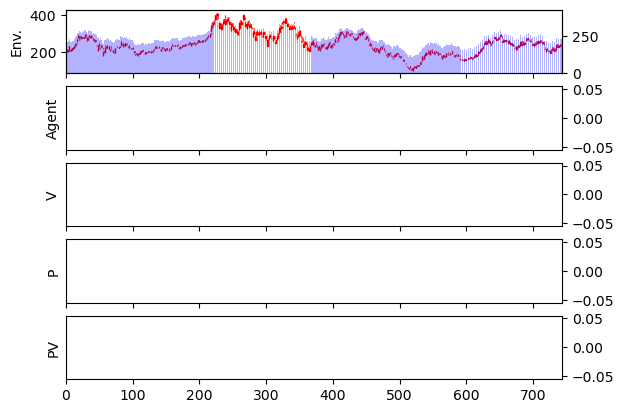

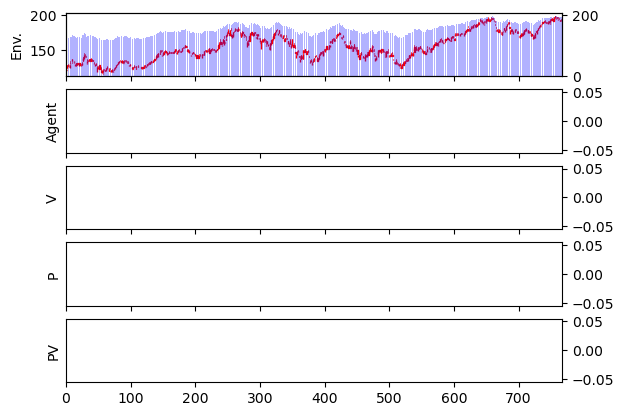

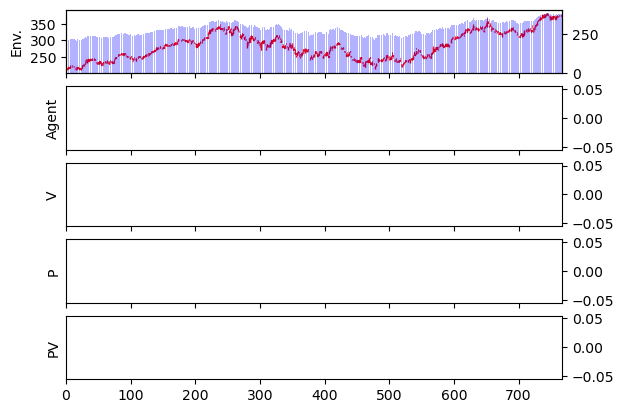

In [36]:
run_trader(stock_names=['Tesla', 'Apple', 'Miscrosoft'], stock_codes=['TSLA', 'AAPL', 'MSFT'], net='alex', rl_method='a3c', num_epochs=1000)